In [1]:
import sys
# append the path of the parent directory
sys.path.append("..")

In [19]:
import math
import os
import time


import numpy as np
np.set_printoptions(legacy='1.25')

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

import seaborn as sns
import time
import json
import pandas as pd
from ctypes import c_int32
from itertools import product
import copy


from tqdm import tqdm

from scipy.stats import pearsonr
from importlib import reload

import orjson
import gzip

from scipy.stats import entropy



from lib import sketches, visualization_utils, encoders, ploting, pacha_sketch
reload(ploting)
reload(sketches)
reload(visualization_utils)
reload(encoders)

reload(pacha_sketch)

from lib.sketches import BloomFilter, CountMinSketch, H3HashFunctions, HashFunctionFamily,\
      CountMinSketchHadamard, CountMinSketchLocalHashing, deterministic_hash, simple_deterministic_hash
from lib.visualization_utils import visualize_badic_cover, plot_b_adic_cubes
from lib.encoders import minimal_b_adic_cover, minimal_spatial_b_adic_cover, BAdicCube, BAdicRange, \
      minimal_b_adic_cover_array, downgrade_b_adic_range_indices
from lib.pacha_sketch import PachaSketch, ADTree, BFParameters, CMParameters, cartesian_product

from lib.ploting import set_style, plot_ylabel, plot_legend

from lib import baselines
reload(baselines)

from lib.baselines import CentralDPServer, LDPServer, LDPEncoderGRR, filter_df, query_df, \
      infer_domains_and_ranges, translate_query_region, evaluate_queries, check_accruracy, \
      evaluate_queries_baselines, evaluate_equivalent_pacha_sketches

# set_style()

In [3]:
delta = 0.01
abs_error_eps = 1.0
epsilon = 0.5

In [4]:
epsilon_values = [0.5, 1.0, 2.0, 4.0]
n_silos= 5

# Online Retail

In [40]:
retail_df = pd.read_parquet("../data/clean/online_retail_no_outliers.parquet")

In [41]:
query_path = "../queries/online_retail_2_cols.json"
with open(query_path, 'rb') as f:
    queries = orjson.loads(f.read())

query_path = "../queries/online_retail_4_cols.json"
with open(query_path, 'rb') as f:
    queries_4 = orjson.loads(f.read())

queries["queries"] = queries["queries"]
queries_4["queries"] = queries_4["queries"]

ad_tree = ADTree.from_json("../sketches/ad_trees/online_retail.json")


## Pacha Sketch

### No differential privacy

In [42]:
p_sketch = PachaSketch.build_with_uniform_size(
    levels=6,
    num_dimensions=6,
    cat_col_map=[0,1,2],
    num_col_map=[3,4,5],
    bases=[2,2,2],
    ad_tree=ad_tree,
    cm_params=CMParameters(delta=delta, error_eps=abs_error_eps / len(retail_df)),
    cat_index_parameters=BFParameters(n_values=len(retail_df)*4, p=0.01),
    num_index_parameters=BFParameters(n_values=len(retail_df)*5, p=0.01),
    region_index_parameters= BFParameters(n_values=len(retail_df)*(5+4), p=0.01))
p_sketch.get_size()

177.99975967407227

In [20]:
p_sketch.save_to_file("../sketches/real_world/online_retail_uniform_array.json.gz")
p_sketch = PachaSketch.from_json("../sketches/real_world/online_retail_uniform.json.gz")

In [43]:
p_sketch.update_data_frame(retail_df)

Updating:   0%|          | 0/536494 [00:00<?, ?it/s]/home/rudi/artifacts/pacha_sketch_prototype/experiments/../lib/pacha_sketch.py:623: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cat_values = tuple(element[i] for i in self.cat_col_map)
/home/rudi/artifacts/pacha_sketch_prototype/experiments/../lib/pacha_sketch.py:624: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  num_values = tuple(element[i] for i in self.num_col_map)
Updating: 100%|██████████| 536494/536494 [02:54<00:00, 3074.29it/s]


In [11]:
ps_results_2 = evaluate_queries(retail_df, queries["queries"], p_sketch, path_to_file="../results/accuracy/retail_2_p_sketch.csv")

Computing true counts...


True Count: 100%|██████████| 200/200 [00:04<00:00, 45.66it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [08:32<00:00,  2.56s/it]


In [124]:
ps_results_4 = evaluate_queries(retail_df, queries_4["queries"], p_sketch, path_to_file="../results/accuracy/retail_4_p_sketch.csv")

Computing true counts...


True Count: 100%|██████████| 200/200 [00:06<00:00, 32.63it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:24<00:00,  8.09it/s]


### Central DP

In [126]:
p_sketches_dp = np.empty(len(epsilon_values), dtype=object)
for i, eps in enumerate(epsilon_values):
    p_sketches_dp[i] = PachaSketch.build_with_uniform_size(
        levels=6,
        num_dimensions=6,
        cat_col_map=[0,1,2],
        num_col_map=[3,4,5],
        bases=[2,2,2],
        ad_tree=ad_tree,
        cm_params=CMParameters(delta=delta, error_eps=abs_error_eps / len(retail_df)),
        cat_index_parameters=BFParameters(n_values=len(retail_df)*4, p=0.01),
        num_index_parameters=BFParameters(n_values=len(retail_df)*5, p=0.01),
        region_index_parameters= BFParameters(n_values=len(retail_df)*(5+4), p=0.01), epsilon=eps)

In [127]:
for p_sketch_dp in p_sketches_dp:
    p_sketch_dp.update_data_frame(retail_df)

Updating:   0%|          | 0/536494 [00:00<?, ?it/s]/home/rudi/artifacts/pacha_sketch_prototype/experiments/../lib/pacha_sketch.py:623: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cat_values = tuple(element[i] for i in self.cat_col_map)
/home/rudi/artifacts/pacha_sketch_prototype/experiments/../lib/pacha_sketch.py:624: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  num_values = tuple(element[i] for i in self.num_col_map)
Updating: 100%|██████████| 536494/536494 [07:30<00:00, 1191.99it/s]


In [29]:
dir_path = "../results/accuracy"
file_names = [f"retail_2_p_sketch_dp_{eps}.csv" for eps in epsilon_values]

evaluate_equivalent_pacha_sketches(df=retail_df, 
                                    p_sketches=p_sketches_dp, 
                                    queries=queries["queries"], 
                                    dir_path=dir_path, 
                                    file_names=file_names)

Computing true counts...


True Count: 100%|██████████| 200/200 [00:04<00:00, 43.96it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [08:55<00:00,  2.68s/it]


In [129]:
dir_path = "../results/accuracy"
file_names = [f"retail_4_p_sketch_dp_{eps}.csv" for eps in epsilon_values]

evaluate_equivalent_pacha_sketches(df=retail_df, 
                                    p_sketches=p_sketches_dp, 
                                    queries=queries_4["queries"], 
                                    dir_path=dir_path, 
                                    file_names=file_names)

Computing true counts...


True Count: 100%|██████████| 200/200 [00:07<00:00, 27.27it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:27<00:00,  7.36it/s]


### Local Differentially Private

##### Increasing Epsilon

In [18]:
p_sketches_ldp = np.empty(len(epsilon_values), dtype=object)
for i, eps in enumerate(epsilon_values):
    p_sketches_ldp[i] = PachaSketch.build_with_uniform_size_ldp(
        levels=6,
        num_dimensions=6,
        cat_col_map=[0,1,2],
        num_col_map=[3,4,5],
        bases=[2,2,2],
        ad_tree=ad_tree,
        cm_params=CMParameters(delta=delta, error_eps=abs_error_eps / len(retail_df)),
        cat_index_parameters=BFParameters(n_values=len(retail_df)*4, p=0.01),
        num_index_parameters=BFParameters(n_values=len(retail_df)*5, p=0.01),
        region_index_parameters= BFParameters(n_values=len(retail_df)*(5+4), p=0.01),
        epsilon=eps,
        n_silos=n_silos
    )

In [19]:
for p_sketch_ldp in p_sketches_ldp:
    p_sketch_ldp.update_data_frame(retail_df)

Updating:   0%|          | 0/536494 [00:00<?, ?it/s]/home/rudi/artifacts/pacha_sketch_prototype/experiments/../lib/pacha_sketch.py:623: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cat_values = tuple(element[i] for i in self.cat_col_map)
/home/rudi/artifacts/pacha_sketch_prototype/experiments/../lib/pacha_sketch.py:624: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  num_values = tuple(element[i] for i in self.num_col_map)
Updating: 100%|██████████| 536494/536494 [03:06<00:00, 2882.72it/s]


In [30]:
dir_path = "../results/accuracy"
file_names = [f"retail_2_p_sketch_ldp_{eps}.csv" for eps in epsilon_values]

evaluate_equivalent_pacha_sketches(df=retail_df, 
                                    p_sketches=p_sketches_ldp, 
                                    queries=queries["queries"], 
                                    dir_path=dir_path, 
                                    file_names=file_names)

Computing true counts...


True Count: 100%|██████████| 200/200 [00:04<00:00, 43.32it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [08:55<00:00,  2.68s/it]


In [130]:
dir_path = "../results/accuracy"
file_names = [f"retail_4_p_sketch_ldp_{eps}.csv" for eps in epsilon_values]

evaluate_equivalent_pacha_sketches(df=retail_df, 
                                    p_sketches=p_sketches_ldp, 
                                    queries=queries_4["queries"], 
                                    dir_path=dir_path, 
                                    file_names=file_names)

Computing true counts...


True Count: 100%|██████████| 200/200 [00:06<00:00, 29.14it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:31<00:00,  6.42it/s]


##### Increasing N-silos

In [44]:
silos = [1,5,10,20]
epsilon = 1.0
p_sketches_ldp_silos = np.empty(len(silos), dtype=object)
for i, n_silos in enumerate(silos):
    p_sketches_ldp_silos[i] = copy.deepcopy(p_sketch)

    for j in range(p_sketches_ldp_silos[i].levels):
        p_sketches_ldp_silos[i].base_sketches[j].add_privacy_noise_ldp(epsilon=epsilon, n_silos=n_silos)

    p_sketches_ldp_silos[i].epsilon = epsilon

In [35]:
print(np.sum(p_sketches_ldp_silos[0].base_sketches[0].counters)) 
print(np.sum(p_sketches_ldp_silos[1].base_sketches[0].counters))
print(np.sum(p_sketches_ldp_silos[2].base_sketches[0].counters))
print(np.sum(p_sketches_ldp_silos[3].base_sketches[0].counters))

6503345
6502211
6505537
6500400


In [45]:
dir_path = "../results/accuracy"
file_names = [f"retail_2_p_sketch_ldp_1.0_{n_silos}.csv" for n_silos in silos]

evaluate_equivalent_pacha_sketches(df=retail_df, 
                                    p_sketches=p_sketches_ldp_silos, 
                                    queries=queries["queries"], 
                                    dir_path=dir_path, 
                                    file_names=file_names)

Computing true counts...


True Count: 100%|██████████| 200/200 [00:04<00:00, 40.96it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [09:30<00:00,  2.85s/it]


## Baselines

### LDP

#### Increasing epsilon

In [31]:
ldp_servers = np.empty(len(epsilon_values), dtype=object)
for i, eps in enumerate(epsilon_values):
    per_query_epsilon = eps / (len(queries["queries"]) + 1)
    ldp_servers[i] = LDPServer(retail_df, epsilon=eps, number_of_partitions=n_silos, per_query_epsilon=per_query_epsilon)

for i, ldp in enumerate(ldp_servers):
    file_name = f"../results/accuracy/retail_2_ldp_{epsilon_values[i]}.csv"
    evaluate_queries_baselines(df=retail_df, queries=queries["queries"], baseline=ldp, path_to_file=file_name)
    ldp.reset_budget()


Computing true counts...


True Count: 100%|██████████| 200/200 [00:04<00:00, 42.54it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:05<00:00, 34.50it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:04<00:00, 40.40it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:05<00:00, 35.01it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:04<00:00, 40.20it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:05<00:00, 35.88it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:04<00:00, 40.06it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:05<00:00, 35.67it/s]


In [131]:
ldp_servers = np.empty(len(epsilon_values), dtype=object)
for i, eps in enumerate(epsilon_values):
    per_query_epsilon = eps / (len(queries_4["queries"]) + 1)
    ldp_servers[i] = LDPServer(retail_df, epsilon=eps, number_of_partitions=n_silos, per_query_epsilon=per_query_epsilon)

for i, ldp in enumerate(ldp_servers):
    file_name = f"../results/accuracy/retail_4_ldp_{epsilon_values[i]}.csv"
    evaluate_queries_baselines(df=retail_df, queries=queries_4["queries"], baseline=ldp, path_to_file=file_name)
    ldp.reset_budget()

Computing true counts...


True Count: 100%|██████████| 200/200 [00:06<00:00, 31.14it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:08<00:00, 24.74it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:06<00:00, 28.79it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:08<00:00, 22.76it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:06<00:00, 29.66it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:08<00:00, 24.55it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:06<00:00, 30.25it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:08<00:00, 24.73it/s]


#### Increasing number of queries

In [140]:
2**np.arange(11, 13) 

array([2048, 4096])

In [141]:
epsilon_total = 1.0
# n_queries = 2**np.arange(0, 11) 
n_queries = 2**np.arange(11, 13) 

ldp_servers = np.empty(len(n_queries), dtype=object)
for i, n in enumerate(n_queries):
    per_query_epsilon = epsilon_total / n
    eps = per_query_epsilon * n
    ldp_servers[i] = LDPServer(retail_df, epsilon=eps, number_of_partitions=n_silos, per_query_epsilon=per_query_epsilon)

for i, ldp in enumerate(ldp_servers):
    file_name = f"../results/accuracy/retail_2_ldp_nq_{n_queries[i]}.csv"
    evaluate_queries_baselines(df=retail_df, queries=queries["queries"], baseline=ldp, path_to_file=file_name)
    ldp.reset_budget()

Computing true counts...


True Count: 100%|██████████| 200/200 [00:04<00:00, 43.24it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:05<00:00, 37.12it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:04<00:00, 42.10it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:05<00:00, 36.75it/s]


In [165]:
epsilon_total = 0.5
# n_queries = 2**np.arange(0, 11) 
n_queries = 2**np.arange(0, 13) 

ldp_servers = np.empty(len(n_queries), dtype=object)
for i, n in enumerate(n_queries):
    per_query_epsilon = epsilon_total / n
    eps = per_query_epsilon * n
    ldp_servers[i] = LDPServer(retail_df, epsilon=eps, number_of_partitions=n_silos, per_query_epsilon=per_query_epsilon)

for i, ldp in enumerate(ldp_servers):
    file_name = f"../results/accuracy/retail_2_ldp_0.5_nq_{n_queries[i]}.csv"
    evaluate_queries_baselines(df=retail_df, queries=queries["queries"], baseline=ldp, path_to_file=file_name)
    ldp.reset_budget()

Computing true counts...


True Count: 100%|██████████| 200/200 [00:07<00:00, 27.66it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:08<00:00, 22.82it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:07<00:00, 26.38it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:09<00:00, 22.19it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:07<00:00, 27.36it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:09<00:00, 22.12it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:07<00:00, 27.46it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:08<00:00, 22.58it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:07<00:00, 26.19it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:08<00:00, 23.44it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:07<00:00, 27.88it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:08<00:00, 22.66it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:07<00:00, 28.13it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:08<00:00, 23.39it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:07<00:00, 27.91it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:08<00:00, 22.57it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:07<00:00, 27.54it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:08<00:00, 22.73it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:07<00:00, 25.97it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:09<00:00, 21.43it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:07<00:00, 27.22it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:08<00:00, 22.70it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:07<00:00, 27.75it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:09<00:00, 22.14it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:07<00:00, 27.68it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:08<00:00, 23.09it/s]


#### Increasing N-Silos

In [51]:
silos = [1,5,10,20]
epsilon = 1.0
ldp_servers_silos = np.empty(len(silos), dtype=object)
for i, n_silos in enumerate(silos):
    per_query_epsilon = epsilon / (len(queries["queries"]) + 1)
    ldp_servers_silos[i] = LDPServer(retail_df, epsilon=epsilon, number_of_partitions=n_silos, per_query_epsilon=per_query_epsilon)

for i, ldp in enumerate(ldp_servers_silos):
    file_name = f"../results/accuracy/retail_2_ldp_1.0_{silos[i]}.csv"
    evaluate_queries_baselines(df=retail_df, queries=queries["queries"], baseline=ldp, path_to_file=file_name)
    ldp.reset_budget()


Computing true counts...


True Count: 100%|██████████| 200/200 [00:04<00:00, 42.90it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:04<00:00, 42.68it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:04<00:00, 41.79it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:04<00:00, 42.13it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:04<00:00, 42.19it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:05<00:00, 38.95it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:04<00:00, 42.56it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:05<00:00, 36.73it/s]


### GRR

In [33]:
grr_servers = np.empty(len(epsilon_values), dtype=object)
categorical_domains, numerical_ranges = infer_domains_and_ranges(retail_df)
for i, eps in enumerate(epsilon_values):
    grr_servers[i] = LDPEncoderGRR(df=retail_df, epsilon=eps, categorical_domains=categorical_domains, numerical_ranges=numerical_ranges)

for i, grr in enumerate(grr_servers):
    file_name = f"../results/accuracy/retail_2_grr_{epsilon_values[i]}.csv"
    evaluate_queries_baselines(df=retail_df, queries=queries["queries"], baseline=grr, path_to_file=file_name)

Privatizing rows: 100%|██████████| 536494/536494 [02:26<00:00, 3661.22it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:05<00:00, 38.63it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:06<00:00, 31.12it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:05<00:00, 38.84it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:06<00:00, 30.42it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:05<00:00, 39.50it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:06<00:00, 29.05it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:05<00:00, 39.80it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:06<00:00, 32.05it/s]


In [133]:
for i, grr in enumerate(grr_servers):
    file_name = f"../results/accuracy/retail_4_grr_{epsilon_values[i]}.csv"
    evaluate_queries_baselines(df=retail_df, queries=queries_4["queries"], baseline=grr, path_to_file=file_name)

Computing true counts...


True Count: 100%|██████████| 200/200 [00:07<00:00, 27.08it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:10<00:00, 19.50it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:07<00:00, 26.90it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:10<00:00, 19.00it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:06<00:00, 29.37it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:10<00:00, 18.57it/s]


Computing true counts...


True Count: 100%|██████████| 200/200 [00:06<00:00, 30.09it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [00:09<00:00, 20.20it/s]


# Plots

In [29]:
def repeat_results(field_to_collect, n_repetitions, file_name):
    results_df = pd.read_csv(file_name)
    median = results_df[field_to_collect].median()
    q25 = results_df[field_to_collect].quantile(0.25)
    q75 = results_df[field_to_collect].quantile(0.75)

    median = np.full(n_repetitions, median)
    q25 = np.full(n_repetitions, q25)
    q75 = np.full(n_repetitions, q75)

    return median, q25, q75

In [24]:
def collect_results(field_to_collect, file_names, dir_path="../results/accuracy"):
    res_medians = np.empty(len(file_names), dtype=float)
    res_q25 = np.empty(len(file_names), dtype=float)
    res_q75 = np.empty(len(file_names), dtype=float)
    for i, file_name in enumerate(file_names):
        results_df = pd.read_csv(f"{dir_path}/{file_name}")
        res_medians[i] = results_df[field_to_collect].median()
        res_q25[i] = results_df[field_to_collect].quantile(0.25)
        res_q75[i] = results_df[field_to_collect].quantile(0.75)
    return res_medians, res_q25, res_q75

In [25]:
def compute_relative_entropy(results_df: pd.DataFrame) -> float:
    # Ensure no negative or zero values for entropy calculation
    true_counts = results_df['true_counts'].clip(lower=1).astype(float)
    estimates = results_df['estimates'].clip(lower=1).astype(float)

    # Normalize to probability distributions
    true_dist = true_counts / true_counts.sum()
    est_dist = estimates / estimates.sum()

    # Compute relative entropy (Kullback-Leibler divergence)
    relative_entropy = entropy(true_dist, est_dist)
    return relative_entropy

In [26]:
def collect_relative_entropies(file_names, dir_path="../results/accuracy"):
    relative_entropies = np.empty(len(file_names), dtype=float)
    for i, file_name in enumerate(file_names):
        results_df = pd.read_csv(f"{dir_path}/{file_name}")
        relative_entropies[i] = compute_relative_entropy(results_df)
    return relative_entropies

## Accuracy increasing epsilon

In [153]:
epsilon_values = [0.5, 1.0, 2.0, 4.0]
# type_of_error = "relative_error"
type_of_error = "normalized_error"

# Normal Pacha Sketch results
p_sketch_results_2_df = pd.read_csv("../results/accuracy/retail_2_p_sketch.csv")
p_sketch_median = p_sketch_results_2_df[type_of_error].median()
p_sketch_q25 = p_sketch_results_2_df[type_of_error].quantile(0.25)
p_sketch_q75 = p_sketch_results_2_df[type_of_error].quantile(0.75)

p_sketch_median = np.full(len(epsilon_values), p_sketch_median)
p_sketch_q25 = np.full(len(epsilon_values), p_sketch_q25)
p_sketch_q75 = np.full(len(epsilon_values), p_sketch_q75)

# Pacha Sketch DP results
p_sketch_dp_files = [f"retail_2_p_sketch_dp_{eps}.csv" for eps in epsilon_values]
p_sketch_dp_median, p_sketch_dp_q25, p_sketch_dp_q75 = collect_results(
    field_to_collect=type_of_error,
    file_names=p_sketch_dp_files,
    dir_path="../results/accuracy"
)

# Pacha Sketch LDP results
p_sketch_ldp_files = [f"retail_2_p_sketch_ldp_{eps}.csv" for eps in epsilon_values]
p_sketch_ldp_median, p_sketch_ldp_q25, p_sketch_ldp_q75 = collect_results(
    field_to_collect=type_of_error,
    file_names=p_sketch_ldp_files,
    dir_path="../results/accuracy"
)

# LDP results
ldp_files = [f"retail_2_ldp_{eps}.csv" for eps in epsilon_values]
ldp_median, ldp_q25, ldp_q75 = collect_results(
    field_to_collect=type_of_error,
    file_names=ldp_files,
    dir_path="../results/accuracy"
)

# GRR results
grr_files = [f"retail_2_grr_{eps}.csv" for eps in epsilon_values]
grr_median, grr_q25, grr_q75 = collect_results(
    field_to_collect=type_of_error,
    file_names=grr_files,
    dir_path="../results/accuracy"
)

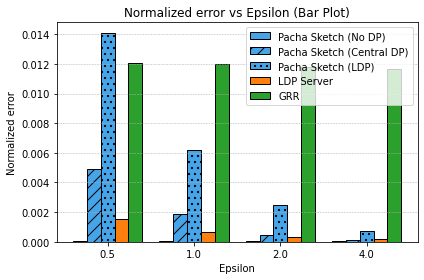

In [157]:
colors = ['#46a4e8', '#46a4e8', '#46a4e8', 'tab:orange', 'tab:green']
hatches = ['', '//', '..', '', '']
methods = ['Pacha Sketch (No DP)', 'Pacha Sketch (Central DP)', 'Pacha Sketch (LDP)', 'LDP Server', 'GRR']
medians = [p_sketch_median, p_sketch_dp_median, p_sketch_ldp_median, ldp_median, grr_median]
q25 = [p_sketch_q25, p_sketch_dp_q25, p_sketch_ldp_q25, ldp_q25, grr_q25]
q75 = [p_sketch_q75, p_sketch_dp_q75, p_sketch_ldp_q75, ldp_q75, grr_q75]

x = np.arange(len(epsilon_values))
width = 0.16

plt.figure(figsize=(6, 4))
for i, (median, lower, upper, color, hatch, label) in enumerate(zip(medians, q25, q75, colors, hatches, methods)):
    err = [median - lower, upper - median]
    # plt.bar(x + i*width - width*2, median, width=width, yerr=err, label=label, color=color, hatch=hatch, capsize=4, edgecolor='black')
    plt.bar(x + i*width - width*2, median, width=width, label=label, color=color, hatch=hatch, capsize=4, edgecolor='black')

label = type_of_error.replace('_', ' ').capitalize()
plt.xticks(x, epsilon_values)
plt.xlabel("Epsilon")
plt.ylabel(label)
# plt.yscale("log")
# for y in [0.001, 0.01, 0.1, 1]:
#     plt.axhline(y, color='gray', linestyle='--', linewidth=0.7, alpha=0.5)
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

plt.legend()
plt.title(f"{label} vs Epsilon (Bar Plot)")
plt.tight_layout()
plt.savefig("../figures/accuracy/accuracy_vs_epsilon_bar_plot.png", dpi=300)
plt.show()


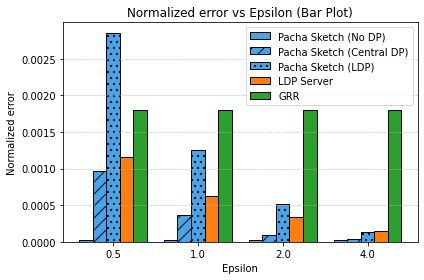

In [158]:
epsilon_values = [0.5, 1.0, 2.0, 4.0]
# type_of_error = "relative_error"
type_of_error = "normalized_error"
# type_of_error = "absolute_error"

# Normal Pacha Sketch results
p_sketch_results_2_df = pd.read_csv("../results/accuracy/retail_4_p_sketch.csv")
p_sketch_median = p_sketch_results_2_df[type_of_error].median()
p_sketch_q25 = p_sketch_results_2_df[type_of_error].quantile(0.25)
p_sketch_q75 = p_sketch_results_2_df[type_of_error].quantile(0.75)

p_sketch_median = np.full(len(epsilon_values), p_sketch_median)
p_sketch_q25 = np.full(len(epsilon_values), p_sketch_q25)
p_sketch_q75 = np.full(len(epsilon_values), p_sketch_q75)

# Pacha Sketch DP results
p_sketch_dp_files = [f"retail_4_p_sketch_dp_{eps}.csv" for eps in epsilon_values]
p_sketch_dp_median, p_sketch_dp_q25, p_sketch_dp_q75 = collect_results(
    field_to_collect=type_of_error,
    file_names=p_sketch_dp_files,
    dir_path="../results/accuracy"
)

# Pacha Sketch LDP results
p_sketch_ldp_files = [f"retail_4_p_sketch_ldp_{eps}.csv" for eps in epsilon_values]
p_sketch_ldp_median, p_sketch_ldp_q25, p_sketch_ldp_q75 = collect_results(
    field_to_collect=type_of_error,
    file_names=p_sketch_ldp_files,
    dir_path="../results/accuracy"
)

# LDP results
ldp_files = [f"retail_4_ldp_{eps}.csv" for eps in epsilon_values]
ldp_median, ldp_q25, ldp_q75 = collect_results(
    field_to_collect=type_of_error,
    file_names=ldp_files,
    dir_path="../results/accuracy"
)

# GRR results
grr_files = [f"retail_4_grr_{eps}.csv" for eps in epsilon_values]
grr_median, grr_q25, grr_q75 = collect_results(
    field_to_collect=type_of_error,
    file_names=grr_files,
    dir_path="../results/accuracy"
)

colors = ['#46a4e8', '#46a4e8', '#46a4e8', 'tab:orange', 'tab:green']
hatches = ['', '//', '..', '', '']
methods = ['Pacha Sketch (No DP)', 'Pacha Sketch (Central DP)', 'Pacha Sketch (LDP)', 'LDP Server', 'GRR']
medians = [p_sketch_median, p_sketch_dp_median, p_sketch_ldp_median, ldp_median, grr_median]
q25 = [p_sketch_q25, p_sketch_dp_q25, p_sketch_ldp_q25, ldp_q25, grr_q25]
q75 = [p_sketch_q75, p_sketch_dp_q75, p_sketch_ldp_q75, ldp_q75, grr_q75]

x = np.arange(len(epsilon_values))
width = 0.16

plt.figure(figsize=(6, 4))
for i, (median, lower, upper, color, hatch, label) in enumerate(zip(medians, q25, q75, colors, hatches, methods)):
    err = [median - lower, upper - median]
    # plt.bar(x + i*width - width*2, median, width=width, yerr=err, label=label, color=color, hatch=hatch, capsize=4, edgecolor='black')
    plt.bar(x + i*width - width*2, median, width=width, label=label, color=color, hatch=hatch, capsize=4, edgecolor='black')

label = type_of_error.replace('_', ' ').capitalize()
plt.xticks(x, epsilon_values)
plt.xlabel("Epsilon")
plt.ylabel(label)
# plt.yscale("log")
# for y in [0.001, 0.01, 0.1, 1]:
#     plt.axhline(y, color='gray', linestyle='--', linewidth=0.7, alpha=0.5)
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

plt.legend()
plt.title(f"{label} vs Epsilon (Bar Plot)")
plt.tight_layout()
plt.savefig("../figures/accuracy/accuracy_vs_epsilon_bar_plot_4_predicates.png", dpi=300)
plt.show()

## Relative entropy increasing epsilon

In [159]:
epsilon_values = [0.5, 1.0, 2.0, 4.0]

# Normal Pacha Sketch results
p_sketch_results_2_df = pd.read_csv("../results/accuracy/retail_2_p_sketch.csv")
p_sketch_rel_entropy = compute_relative_entropy(p_sketch_results_2_df)
p_sketch_rel_entropy = np.full(len(epsilon_values), p_sketch_rel_entropy)

# Pacha Sketch DP results
p_sketch_dp_files = [f"retail_2_p_sketch_dp_{eps}.csv" for eps in epsilon_values]
p_sketch_dp_rel_entropy = collect_relative_entropies(
    file_names=p_sketch_dp_files,
    dir_path="../results/accuracy"
)

# Pacha Sketch LDP results
p_sketch_ldp_files = [f"retail_2_p_sketch_ldp_{eps}.csv" for eps in epsilon_values]
p_sketch_ldp_rel_entropy = collect_relative_entropies(
    file_names=p_sketch_ldp_files,
    dir_path="../results/accuracy"
)

# LDP results
ldp_files = [f"retail_2_ldp_{eps}.csv" for eps in epsilon_values]
ldp_rel_entropy = collect_relative_entropies(
    file_names=ldp_files,
    dir_path="../results/accuracy"
)

# GRR results
grr_files = [f"retail_2_grr_{eps}.csv" for eps in epsilon_values]
grr_rel_entropy = collect_relative_entropies(
    file_names=grr_files,
    dir_path="../results/accuracy"
)

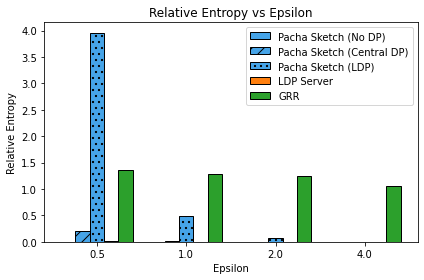

In [160]:
colors = ['#46a4e8', '#46a4e8', '#46a4e8', 'tab:orange', 'tab:green']
hatches = ['', '//', '..', '', '']
methods = ['Pacha Sketch (No DP)', 'Pacha Sketch (Central DP)', 'Pacha Sketch (LDP)', 'LDP Server', 'GRR']
rel_entropies = [p_sketch_rel_entropy, p_sketch_dp_rel_entropy, p_sketch_ldp_rel_entropy, ldp_rel_entropy, grr_rel_entropy]

x = np.arange(len(epsilon_values))
width = 0.16

plt.figure(figsize=(6, 4))
for i, (rel_entropy, color, hatch, label) in enumerate(zip(rel_entropies, colors, hatches, methods)):
    plt.bar(x + i*width - width*2, rel_entropy, width=width, label=label, color=color, hatch=hatch, capsize=4, edgecolor='black')

plt.xticks(x, epsilon_values)
plt.xlabel("Epsilon")
plt.ylabel("Relative Entropy")
# plt.yscale("log")
# for y in 10.0 ** np.arange(-4, 1):
#     plt.axhline(y, color='gray', linestyle='--', linewidth=0.7, alpha=0.5)
plt.legend()
plt.title(f"Relative Entropy vs Epsilon")
plt.savefig("../figures/accuracy/entropy_vs_epsilon_bar_plot.png", dpi=300)
plt.tight_layout()
plt.show()

## Accuracy increasing number of queries

In [168]:
n_queries = 2**np.arange(0, 13)
type_of_error = "normalized_error"
# type_of_error = "relative_error"

# Normal Pacha Sketch results
p_sketch_results_2_df = pd.read_csv("../results/accuracy/retail_2_p_sketch.csv")
p_sketch_median = p_sketch_results_2_df[type_of_error].median()
p_sketch_q25 = p_sketch_results_2_df[type_of_error].quantile(0.25)
p_sketch_q75 = p_sketch_results_2_df[type_of_error].quantile(0.75)

p_sketch_median = np.full(len(n_queries), p_sketch_median)
p_sketch_q25 = np.full(len(n_queries), p_sketch_q25)
p_sketch_q75 = np.full(len(n_queries), p_sketch_q75)

# Pacha Sketch DP results
p_sketch_dp_results_2_df = pd.read_csv("../results/accuracy/retail_2_p_sketch_dp_0.5.csv")
p_sketch_dp_median = p_sketch_dp_results_2_df[type_of_error].median()
p_sketch_dp_q25 = p_sketch_dp_results_2_df[type_of_error].quantile(0.25)
p_sketch_dp_q75 = p_sketch_dp_results_2_df[type_of_error].quantile(0.75)

p_sketch_dp_median = np.full(len(n_queries), p_sketch_dp_median)
p_sketch_dp_q25 = np.full(len(n_queries), p_sketch_dp_q25)
p_sketch_dp_q75 = np.full(len(n_queries), p_sketch_dp_q75)

# Pacha Sketch LDP results
p_sketch_ldp_results_2_df = pd.read_csv("../results/accuracy/retail_2_p_sketch_ldp_0.5.csv")
p_sketch_ldp_median = p_sketch_ldp_results_2_df[type_of_error].median()
p_sketch_ldp_q25 = p_sketch_ldp_results_2_df[type_of_error].quantile(0.25)
p_sketch_ldp_q75 = p_sketch_ldp_results_2_df[type_of_error].quantile(0.75)

p_sketch_ldp_median = np.full(len(n_queries), p_sketch_ldp_median)
p_sketch_ldp_q25 = np.full(len(n_queries), p_sketch_ldp_q25)
p_sketch_ldp_q75 = np.full(len(n_queries), p_sketch_ldp_q75)

# GRR results
grr_results_2_df = pd.read_csv("../results/accuracy/retail_2_grr_0.5.csv")
grr_median = grr_results_2_df[type_of_error].median()
grr_q25 = grr_results_2_df[type_of_error].quantile(0.25)
grr_q75 = grr_results_2_df[type_of_error].quantile(0.75)
grr_median = np.full(len(n_queries), grr_median)
grr_q25 = np.full(len(n_queries), grr_q25)
grr_q75 = np.full(len(n_queries), grr_q75)

# LDP results
# ldp_files = [f"retail_2_ldp_nq_{n}.csv" for n in n_queries]
ldp_files = [f"retail_2_ldp_0.5_nq_{n}.csv" for n in n_queries]
ldp_median, ldp_q25, ldp_q75 = collect_results(
    field_to_collect=type_of_error,
    file_names=ldp_files,
    dir_path="../results/accuracy"
)


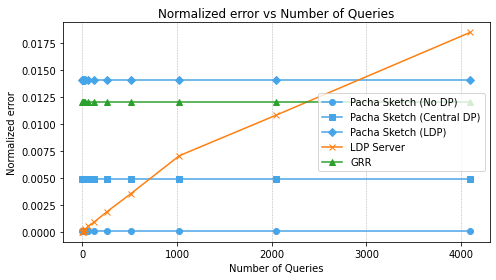

In [169]:
colors = ['#46a4e8', '#46a4e8', '#46a4e8', 'tab:orange', 'tab:green']
methods = ['Pacha Sketch (No DP)', 'Pacha Sketch (Central DP)', 'Pacha Sketch (LDP)', 'LDP Server', 'GRR']
markers = ['o', 's', 'D', 'x', '^']
medians = [p_sketch_median, p_sketch_dp_median, p_sketch_ldp_median, ldp_median, grr_median]
q25 = [p_sketch_q25, p_sketch_dp_q25, p_sketch_ldp_q25, ldp_q25, grr_q25]
q75 = [p_sketch_q75, p_sketch_dp_q75, p_sketch_ldp_q75, ldp_q75, grr_q75]

plt.figure(figsize=(7, 4))
for median, lower, upper, label, color, marker in zip(medians, q25, q75, methods, colors, markers):
    plt.plot(n_queries, median, marker=marker, label=label, color=color)
    # plt.fill_between(n_queries, lower, upper, alpha=0.2, color=color)

type_of_error_label = type_of_error.replace('_', ' ').capitalize()
plt.xlabel("Number of Queries")
plt.ylabel(type_of_error_label)
# plt.yscale("log")
# for y in [0.00001,0.0001, 0.001, 0.01]:
#     plt.axhline(y, color='gray', linestyle='--', linewidth=0.7, alpha=0.5)

plt.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)
# plt.xticks(n_queries)
plt.title(f"{type_of_error_label} vs Number of Queries")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/accuracy/accuracy_vs_n_queries_0.5.png", dpi=300)
plt.show()

## Increasing N-Silos

In [52]:
silos = [1,5,10,20]
# type_of_error = "relative_error"
type_of_error = "normalized_error"

# Normal Pacha Sketch results
p_sketch_median, p_sketch_q25, p_sketch_q75 = repeat_results(field_to_collect=type_of_error, 
                                                             n_repetitions=len(silos), 
                                                             file_name="../results/accuracy/retail_2_p_sketch.csv")

# Pacha Sketch DP results

p_sketch_dp_median, p_sketch_dp_q25, p_sketch_dp_q75 = repeat_results(field_to_collect=type_of_error, 
                                                             n_repetitions=len(silos), 
                                                             file_name="../results/accuracy/retail_2_p_sketch_dp_1.0.csv")

# Pacha Sketch LDP results
p_sketch_ldp_files = [f"retail_2_p_sketch_ldp_1.0_{n_silos}.csv" for n_silos in silos]
p_sketch_ldp_median, p_sketch_ldp_q25, p_sketch_ldp_q75 = collect_results(
    field_to_collect=type_of_error,
    file_names=p_sketch_ldp_files,
    dir_path="../results/accuracy"
)

# LDP results
ldp_files = [f"retail_2_ldp_1.0_{n_silos}.csv" for n_silos in silos]
ldp_median, ldp_q25, ldp_q75 = collect_results(
    field_to_collect=type_of_error,
    file_names=ldp_files,
    dir_path="../results/accuracy"
)

# GRR results
grr_median, grr_q25, grr_q75 = repeat_results(field_to_collect=type_of_error,
                                              n_repetitions=len(silos),
                                              file_name="../results/accuracy/retail_2_grr_1.0.csv")

In [47]:
p_sketch_ldp_median

array([0.0035238 , 0.00949125, 0.01388739, 0.02078868])

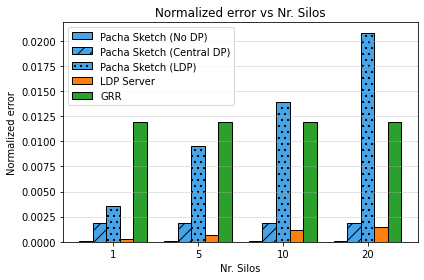

In [53]:
colors = ['#46a4e8', '#46a4e8', '#46a4e8', 'tab:orange', 'tab:green']
hatches = ['', '//', '..', '', '']
methods = ['Pacha Sketch (No DP)', 'Pacha Sketch (Central DP)', 'Pacha Sketch (LDP)', 'LDP Server', 'GRR']
medians = [p_sketch_median, p_sketch_dp_median, p_sketch_ldp_median, ldp_median, grr_median]
q25 = [p_sketch_q25, p_sketch_dp_q25, p_sketch_ldp_q25, ldp_q25, grr_q25]
q75 = [p_sketch_q75, p_sketch_dp_q75, p_sketch_ldp_q75, ldp_q75, grr_q75]

x = np.arange(len(silos))
width = 0.16

plt.figure(figsize=(6, 4))
for i, (median, lower, upper, color, hatch, label) in enumerate(zip(medians, q25, q75, colors, hatches, methods)):
    err = [median - lower, upper - median]
    # plt.bar(x + i*width - width*2, median, width=width, yerr=err, label=label, color=color, hatch=hatch, capsize=4, edgecolor='black')
    plt.bar(x + i*width - width*2, median, width=width, label=label, color=color, hatch=hatch, capsize=4, edgecolor='black')

label = type_of_error.replace('_', ' ').capitalize()
plt.xticks(x, silos)
plt.xlabel("Nr. Silos")
plt.ylabel(label)
# plt.yscale("log")
# for y in [0.001, 0.01, 0.1, 1]:
#     plt.axhline(y, color='gray', linestyle='--', linewidth=0.7, alpha=0.5)
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

plt.legend()
plt.title(f"{label} vs Nr. Silos")
plt.tight_layout()
plt.savefig("../figures/accuracy/accuracy_vs_silos_bar_plot.png", dpi=300)
plt.show()
